In [1]:
import pandas as pd
import sklearn
import numpy as np
from scipy import optimize
from scipy.optimize import brute
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn2pmml.pipeline import PMMLPipeline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/application_record.csv')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


count    4.385570e+05
mean     1.875243e+05
std      1.100869e+05
min      2.610000e+04
25%      1.215000e+05
50%      1.607805e+05
75%      2.250000e+05
max      6.750000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

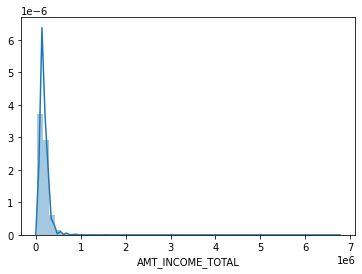

In [4]:
import seaborn as sns

sns.distplot(df['AMT_INCOME_TOTAL'])

df['AMT_INCOME_TOTAL'].describe()

count    438127.000000
mean     186132.246781
std       95749.993879
min       26100.000000
25%      121500.000000
50%      157500.000000
75%      225000.000000
max      990000.000000
Name: AMT_INCOME_TOTAL, dtype: float64

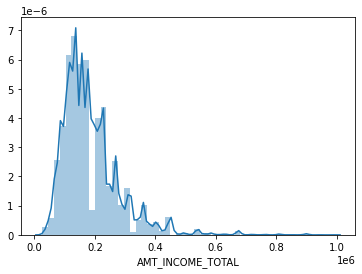

In [5]:
df = df[df['AMT_INCOME_TOTAL']<1e6]
sns.distplot(df['AMT_INCOME_TOTAL'])

df['AMT_INCOME_TOTAL'].describe()

In [6]:
df['AGE'] = -df['DAYS_BIRTH']/365.0
df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']

In [7]:
# drop bad columns
df = df.dropna()

In [8]:
from random import random
def calculate_approval(row):
    p = 1.0

    if row['AGE'] < 25:
        p = p - 0.4
    elif row['AGE'] >= 25 and row['AGE'] < 50:
        p = p - 0.2
    elif row['AGE'] >= 50:
        p = p -  0.1

    if row['CNT_CHILDREN'] == 0:
        p = p -  0.1
    elif row['CNT_CHILDREN'] > 0 and row['CNT_CHILDREN'] < 2:
        p = p - 0.2
    else:
        p = p - 0.3

    if row['AMT_INCOME_TOTAL'] < 100000:
        p = p - 0.3
    elif row['AMT_INCOME_TOTAL'] >= 100000 and row['AMT_INCOME_TOTAL'] < 200000:
        p = p - 0.2
    elif row['AMT_INCOME_TOTAL'] >= 200000 and row['AMT_INCOME_TOTAL'] < 300000:
        p = p - 0.1

    if row['DAYS_EMPLOYED'] < 365:
        p = p -  0.2
    elif row['DAYS_EMPLOYED'] >= 365 and row['DAYS_EMPLOYED'] < 2000:
        p = p - 0.1

    if row['FLAG_OWN_REALTY'] == 0.0:
        p = p -  0.1

    if row['FLAG_OWN_CAR'] == 0.0:
        p = p - 0.05

    return random() < p



df['APPROVED'] = df.apply(calculate_approval, axis=1)
df['APPROVED'].describe()

count     303930
unique         2
top        False
freq      168767
Name: APPROVED, dtype: object

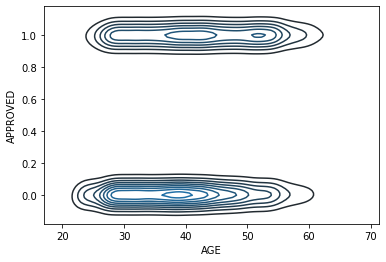

In [9]:
import seaborn as sns

sns.kdeplot(df['AGE'], df['APPROVED'])

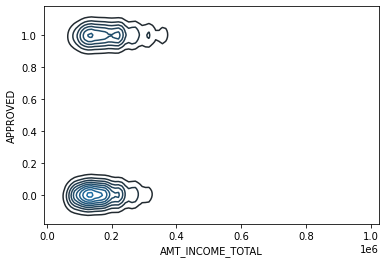

In [10]:
sns.kdeplot(df['AMT_INCOME_TOTAL'], df['APPROVED'])

In [11]:
inputs = df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE']]
outputs = df['APPROVED'].eq(True).mul(1)
inputs['FLAG_OWN_CAR'] = inputs['FLAG_OWN_CAR'].eq('Y').mul(1)
inputs['FLAG_OWN_REALTY'] = inputs['FLAG_OWN_REALTY'].eq('Y').mul(1)

In [12]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [13]:
X_train

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED,FLAG_WORK_PHONE
77799,1,0,1,225000.0,39.235616,501,0
261430,0,1,0,202500.0,63.145205,6629,0
392494,0,1,0,112500.0,54.602740,2472,0
258758,1,1,0,180000.0,48.295890,537,0
302647,1,0,0,315000.0,51.473973,4301,0
...,...,...,...,...,...,...,...
292473,0,1,0,135000.0,34.887671,644,0
392386,1,1,0,202500.0,29.509589,1685,0
321505,1,1,1,450000.0,37.336986,389,0
391744,1,1,1,342000.0,36.912329,1245,0


In [14]:
from sklearn_pandas import DataFrameMapper

def build_RF_pipeline(inputs, outputs, categorical, numerical, rf=None):
    if not rf:
        rf = RandomForestClassifier()
    pipeline = PMMLPipeline([
        ("mapper", DataFrameMapper([
            (categorical, preprocessing.OrdinalEncoder()),
            (numerical, None)
        ])),
        ("classifier", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [15]:

def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=50, stop=100, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(3, 10, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [1, 2, 4]
    if not min_samples_leaf:
        min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return best_random

In [16]:
rf = RF_estimation(X_train, y_train, estimator_steps=4, depth_steps=4)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE'], ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'DAYS_EMPLOYED'], rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished
RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=83)


In [17]:
rf_predictions = random_forest_pipeline.predict(X_test)
print(f"MSE: {random_forest_pipeline.score(X_test, y_test)*100}%")

MSE: 62.412397591550686%


In [18]:
from sklearn2pmml import sklearn2pmml

sklearn2pmml(random_forest_pipeline, "../models/loan.pmml", with_repr = True)

## Stuck in a local maximum

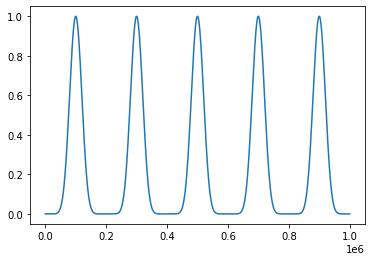

In [56]:
n = np.linspace(0, 1e6, 10000)
income_probability = np.power(np.abs(np.sin((2.0*np.pi / 400000.0) * n)), 10)
sns.lineplot(n, income_probability)

In [57]:
income_probability

array([0.00000000e+000, 9.15442983e-029, 9.37402048e-026, ...,
       9.37402048e-026, 9.15442983e-029, 6.04755974e-147])

In [58]:
f = np.vectorize(lambda x: random() < x)
approved = f(income_probability)

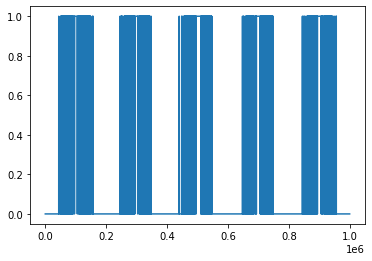

In [59]:
sns.lineplot(n, approved)

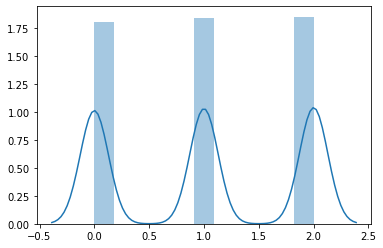

In [61]:
n_children = np.random.randint(3, size=10000)
sns.distplot(n_children)

In [62]:
df2 = pd.DataFrame(
{'CNT_CHILDREN': n_children,
    'AMT_INCOME_TOTAL': n,
    'APPROVED': approved
})

In [64]:
df2.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL
count,10000.000000,10000.000000
mean,1.008400,500000.000000
std,0.815963,288718.439835
min,0.000000,0.000000
25%,0.000000,250000.000000
50%,1.000000,500000.000000
75%,2.000000,750000.000000
max,2.000000,1000000.000000
